## 1. Fit the Random Forest classifier to your training sample and transform (i.e. make predictions on the training sample) setting the random_state accordingly and setting min_samples_leaf = 1 and max_depth = 10.

In [1]:
import pydataset
from env import get_db_url

import pandas as pd
import numpy as np

from prepare import prep_titanic
from prepare import titanic_split

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = prep_titanic()
df['baseline_prediction'] = 0
df.head()

,passenger_id,survived,pclass,sex,sibsp,parch,fare,embarked,alone,sex_male,embarked_Q,embarked_S,baseline_prediction
0,0,0,3,male,1,0,7.2500,S,0,1,0,1,0
1,1,1,1,female,1,0,71.2833,C,0,0,0,0,0
2,2,1,3,female,0,0,7.9250,S,1,0,0,1,0
3,3,1,1,female,1,0,53.1000,S,0,0,0,1,0
4,4,0,3,male,0,0,8.0500,S,1,1,0,1,0


In [3]:
df.survived.value_counts()

0    549
1    342
Name: survived, dtype: int64

## Baseline Accuracy

In [4]:
baseline_accuracy = (df.survived == df.baseline_prediction).mean()
baseline_accuracy

0.6161616161616161

## Cleaning the Data a little further

In [5]:
df['fare'] = df['fare'].astype('float64')

In [6]:
bins = [0, 25, 105, 205, 405, 600]
labels = [1, 2, 3, 4, 5]
df['fare_bin'] = pd.cut(df['fare'], bins=bins, labels=labels)

In [7]:
# df.pclass.get_dummies()
# Assuming df is your DataFrame
dummy_df = pd.get_dummies(df['pclass'], prefix='pclass')

# Concatenate the dummy variables with the original DataFrame
df = pd.concat([df, dummy_df], axis=1)

In [8]:
df.columns

Index(['passenger_id', 'survived', 'pclass', 'sex', 'sibsp', 'parch', 'fare',
       'embarked', 'alone', 'sex_male', 'embarked_Q', 'embarked_S',
       'baseline_prediction', 'fare_bin', 'pclass_1', 'pclass_2', 'pclass_3'],
      dtype='object')

In [9]:
df.dtypes

passenger_id              int64
survived                  int64
pclass                    int64
sex                      object
sibsp                     int64
parch                     int64
fare                    float64
embarked                 object
alone                     int64
sex_male                  uint8
embarked_Q                uint8
embarked_S                uint8
baseline_prediction       int64
fare_bin               category
pclass_1                  uint8
pclass_2                  uint8
pclass_3                  uint8
dtype: object

## Train, Validate, Test

In [10]:
df, train, validate, test = titanic_split(df)

In [11]:
# inspect
train.info(), validate.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 534 entries, 455 to 496
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   passenger_id         534 non-null    int64   
 1   survived             534 non-null    int64   
 2   pclass               534 non-null    int64   
 3   sex                  534 non-null    object  
 4   sibsp                534 non-null    int64   
 5   parch                534 non-null    int64   
 6   fare                 534 non-null    float64 
 7   embarked             534 non-null    object  
 8   alone                534 non-null    int64   
 9   sex_male             534 non-null    uint8   
 10  embarked_Q           534 non-null    uint8   
 11  embarked_S           534 non-null    uint8   
 12  baseline_prediction  534 non-null    int64   
 13  fare_bin             525 non-null    category
 14  pclass_1             534 non-null    uint8   
 15  pclass_2             

(None, None, None)

## Removing the lesser columns

In [12]:
# create X & y version of train/validate/test
# where X contains the features we want to use and y is a series with just the target variable

X_train = train.drop(columns=['passenger_id', 'survived', 'sex', 'fare', 'embarked', 'embarked_Q', 
        'embarked_S', 'baseline_prediction'])
y_train = train.survived
X_validate = validate.drop(columns=['passenger_id', 'survived', 'sex',  'fare', 'embarked', 'embarked_Q', 
        'embarked_S', 'baseline_prediction'])
y_validate = validate.survived
X_test = test.drop(columns=['passenger_id', 'survived', 'sex', 'fare', 'embarked', 'embarked_Q', 
        'embarked_S', 'baseline_prediction'])
y_test = test.survived

In [13]:
X_train.shape, y_train.shape, X_validate.shape, y_validate.shape

((534, 9), (534,), (178, 9), (178,))

## Columns to train and validate

In [14]:
#Compare df columns

print(f"""train:
{train.columns.to_list()} 
_____________________________________________
X_train:
{X_train.columns.to_list()}
_____________________________________________
X_validate:
{X_validate.columns.to_list()}
""")

train:
['passenger_id', 'survived', 'pclass', 'sex', 'sibsp', 'parch', 'fare', 'embarked', 'alone', 'sex_male', 'embarked_Q', 'embarked_S', 'baseline_prediction', 'fare_bin', 'pclass_1', 'pclass_2', 'pclass_3'] 
_____________________________________________
X_train:
['pclass', 'sibsp', 'parch', 'alone', 'sex_male', 'fare_bin', 'pclass_1', 'pclass_2', 'pclass_3']
_____________________________________________
X_validate:
['pclass', 'sibsp', 'parch', 'alone', 'sex_male', 'fare_bin', 'pclass_1', 'pclass_2', 'pclass_3']



## Creating A function to Fit and Transom my data

In [15]:
def RandomForest(k, l, X, y):
    # k=max_depth
    # l=min_samples_leaf
    rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=l,
                            n_estimators=100,
                            max_depth=k, 
                            random_state=123)

    
    rf.fit(X, y)
    
    y_trn_pred = rf.predict(X)
    
    y_trn_proba = rf.predict_proba(X)
    
    
    return y_trn_pred, y_trn_proba, k, l, rf

In [16]:
y_pred, y_proba, k, l, rf = RandomForest(10, 1, X_train, y_train)

In [17]:
y_pred

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,

## 2. Evaluate your results using the model score, confusion matrix, and classification report.


## Creating a Functionn to produce metrics

In [18]:
def decision_metrics(X, y, y_pred, k, l ):

    score = rf.score(X, y)
    cm = confusion_matrix(y, y_pred)
    
    cmdf = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], 
                   columns=['Pred 0', 'Pred 1'])
    
    report = classification_report(y, y_pred)
    
    return score, cm, cmdf, report

## Training:
### Extracting the variables from the function and creating a list 

In [19]:
score, cm, cmdf, report = decision_metrics(X_train, y_train, y_pred, k, l)
metric_list = [score, cm, cmdf, report]

### Using the list to print out clearly

In [20]:
list = ['The train score for the model is:', 'Confusion Matrix:', 'Confusion Matrix DataFrame:', 'Classification Report:']
print(f'Model with Max Depth {k},')
print(f'And Leaf level at {l} :')
print()
for i, metric in enumerate(metric_list): # to add number to a tuple ex.: (o, seq[0]), (1, seq[1])
    if i == 2:
        print(list[2])
        display(metric)
        print('--------')
    else:
        print(list[i])
        print(metric)
        print('--------')

Model with Max Depth 10,
And Leaf level at 1 :

The train score for the model is:
0.8520599250936329
--------
Confusion Matrix:
[[302  27]
 [ 52 153]]
--------
Confusion Matrix DataFrame:


,Pred 0,Pred 1
Actual 0,302,27
Actual 1,52,153


--------
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       329
           1       0.85      0.75      0.79       205

    accuracy                           0.85       534
   macro avg       0.85      0.83      0.84       534
weighted avg       0.85      0.85      0.85       534

--------


## 3. Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.


In [21]:
def print_cm_metrics(cm):    
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn)/(tn + fp + fn + tp)

    true_positive_rate = tp/(tp + fn)
    false_positive_rate = fp/(fp + tn)
    true_negative_rate = tn/(tn + fp)
    false_negative_rate = fn/(fn + tp)

    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    f1_score = 2*(precision*recall)/(precision+recall)

    support_pos = tp + fn
    support_neg = fp + tn

    dict = {
        'metric' : ['accuracy'
                    ,'true_positive_rate'
                    ,'false_positive_rate'
                    ,'true_negative_rate'
                    ,'false_negative_rate'
                    ,'precision'
                    ,'recall'
                    ,'f1_score'
                    ,'support_pos'
                    ,'support_neg']
        ,'score' : [accuracy
                    ,true_positive_rate
                    ,false_positive_rate
                    ,true_negative_rate
                    ,false_negative_rate
                    ,precision
                    ,recall
                    ,f1_score
                    ,support_pos
                    ,support_neg]
    }

    return pd.DataFrame(dict)

In [22]:
print_cm_metrics(cm)

,metric,score
0,accuracy,0.852060
1,true_positive_rate,0.746341
2,false_positive_rate,0.082067
3,true_negative_rate,0.917933
4,false_negative_rate,0.253659
5,precision,0.850000
6,recall,0.746341
7,f1_score,0.794805
8,support_pos,205.000000
9,support_neg,329.000000


In [23]:
trn_report = classification_report(y_train, y_pred)
print(trn_report)

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       329
           1       0.85      0.75      0.79       205

    accuracy                           0.85       534
   macro avg       0.85      0.83      0.84       534
weighted avg       0.85      0.85      0.85       534



## 4. Run through steps increasing your min_samples_leaf and decreasing your max_depth.

In [24]:
i = 10
j = 1

# storing my values to use them to create dictiojnaries containg 
# all the collected data for head to head comaprison
train_depth = []
leaf_lvl = []
train_score_list = [] 
val_score_list = []
trn_report_list = []
val_report_list = []
diff_list = []

while j < 11:
        
        y_pred, y_proba, k, l, rf = RandomForest(i, j, X_train, y_train)
#         trn_score, trn_cm, trn_cmdf, trn_report = decision_metrics(X_train, y_train, y_pred, k, l)
#         val_score, val_cm, val_cmdf, val_report = decision_metrics(X_validate, y_validate, y_pred, k, l)
        # Compute score
        trn_score = rf.score(X_train, y_train)
        val_score = rf.score(X_validate, y_validate)
        trn_report = classification_report(y_train, y_pred)
        y_val_pred = rf.predict(X_validate)
        val_report = classification_report(y_validate, y_val_pred)
#         trn_report_list.append(trn_report)
        val_report_list.append(val_report)
        train_score_list.append(trn_score)
        val_score_list.append(val_score)
        train_depth.append(i)
        leaf_lvl.append(j)
        
        print(f'Training Dataset Model with Max Depth of {i},')
        print(f'And Leaf Level of {j}:')
        
        # Print the model's accuracy and other information
        print(f"Model's Accuracy: {trn_score}")
        print(f"Difference between Model and Basleine Accuracy: {trn_score - baseline_accuracy}")
        print('Train Classification Report')
        print(trn_report)
        print()
        print('           VS             ')
        print()
        print(f'Validation Dataset Model with Max Depth of {i},')
        print(f'And Leaf Level of {j}:')
        print(f"Model's Accuracy: {val_score}")
        print(f"Difference between Model and Basleine Accuracy: {val_score - baseline_accuracy}")
        print('Validate Classification Report')
        print(val_report)
        print()
        print(f'Difference bewtween Training and Validate:{trn_score-val_score}')
        #print(val_report)
        print()
        print('----------------------------------------------------')
        print()

        # Increment 'i' and 'j' for the next iteration
        i -= 1
        j += 1
        diff = trn_score-val_score
        diff_list.append(diff)

# create dictionaries for my data collection
train_dict = {(x, y): z for x, y, z in zip(train_depth, leaf_lvl, train_score_list)}
val_dict = {(x, y): z for x, y, z in zip(train_depth, leaf_lvl, val_score_list)}
diff_dict = {(x, y): z for x, y, z in zip(train_depth, leaf_lvl, diff_list)}

model_number = 1
for key, value in diff_dict.items():
    if value == min(diff_dict.values()):
        print()
        print(f'Top Model #{model_number}')
        print('*************FINAL ANALYSIS*************')
        print()
        print(f'''Top performing Training Model:
        Max Depth:{key[0]}
        Leaf Level:{key[1]}
        Accuracy:{max(train_dict.values())}
        
Top performing Validation Model:

        Max Depth:{key[0]}
        Leaf Level:{key[1]}
        Accuracy:{max(val_dict.values())}
        Difference:{min(diff_dict.values())}''')
        model_number+=1

Training Dataset Model with Max Depth of 10,
And Leaf Level of 1:
Model's Accuracy: 0.8520599250936329
Difference between Model and Basleine Accuracy: 0.2358983089320168
Train Classification Report
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       329
           1       0.85      0.75      0.79       205

    accuracy                           0.85       534
   macro avg       0.85      0.83      0.84       534
weighted avg       0.85      0.85      0.85       534


           VS             

Validation Dataset Model with Max Depth of 10,
And Leaf Level of 1:
Model's Accuracy: 0.7865168539325843
Difference between Model and Basleine Accuracy: 0.17035523777096817
Validate Classification Report
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       110
           1       0.73      0.69      0.71        68

    accuracy                           0.79       178
   macro avg       0.78 

Training Dataset Model with Max Depth of 3,
And Leaf Level of 8:
Model's Accuracy: 0.7883895131086143
Difference between Model and Basleine Accuracy: 0.17222789694699814
Train Classification Report
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       329
           1       0.94      0.48      0.63       205

    accuracy                           0.79       534
   macro avg       0.85      0.73      0.74       534
weighted avg       0.82      0.79      0.77       534


           VS             

Validation Dataset Model with Max Depth of 3,
And Leaf Level of 8:
Model's Accuracy: 0.7640449438202247
Difference between Model and Basleine Accuracy: 0.14788332765860857
Validate Classification Report
              precision    recall  f1-score   support

           0       0.74      0.95      0.83       110
           1       0.84      0.47      0.60        68

    accuracy                           0.76       178
   macro avg       0.79  

### Checking results individually before implementing in Final Report

In [25]:
max(train_dict.values()), max(val_dict.values()), diff_dict.keys()

(0.8520599250936329,
 0.8033707865168539,
 dict_keys([(10, 1), (9, 2), (8, 3), (7, 4), (6, 5), (5, 6), (4, 7), (3, 8), (2, 9), (1, 10)]))

In [26]:
print(diff_dict.keys())

dict_keys([(10, 1), (9, 2), (8, 3), (7, 4), (6, 5), (5, 6), (4, 7), (3, 8), (2, 9), (1, 10)])


In [27]:
for key, value in diff_dict.items():
    if value == min(diff_dict.values()):
        print(key)
        print(key[0])
        print(min(diff_dict.values()))
        print(max(val_dict.values()))
        print(max(train_dict.values()))
#01310861423220977

(7, 4)
7
0.01310861423220977
0.8033707865168539
0.8520599250936329
(5, 6)
5
0.01310861423220977
0.8033707865168539
0.8520599250936329


## 5. What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?

In [28]:
key_values = []
for key, value in diff_dict.items():
    key=key[0]
    key_values.append(key)

In [29]:
train_values = train_dict.values()

In [30]:
validate_values = val_dict.values()

In [31]:
diff_values = diff_dict.values()

In [32]:
df = pd.DataFrame({'depth':key_values, 'train_acc':train_values, 'validate_acc':validate_values, 'difference':diff_values})


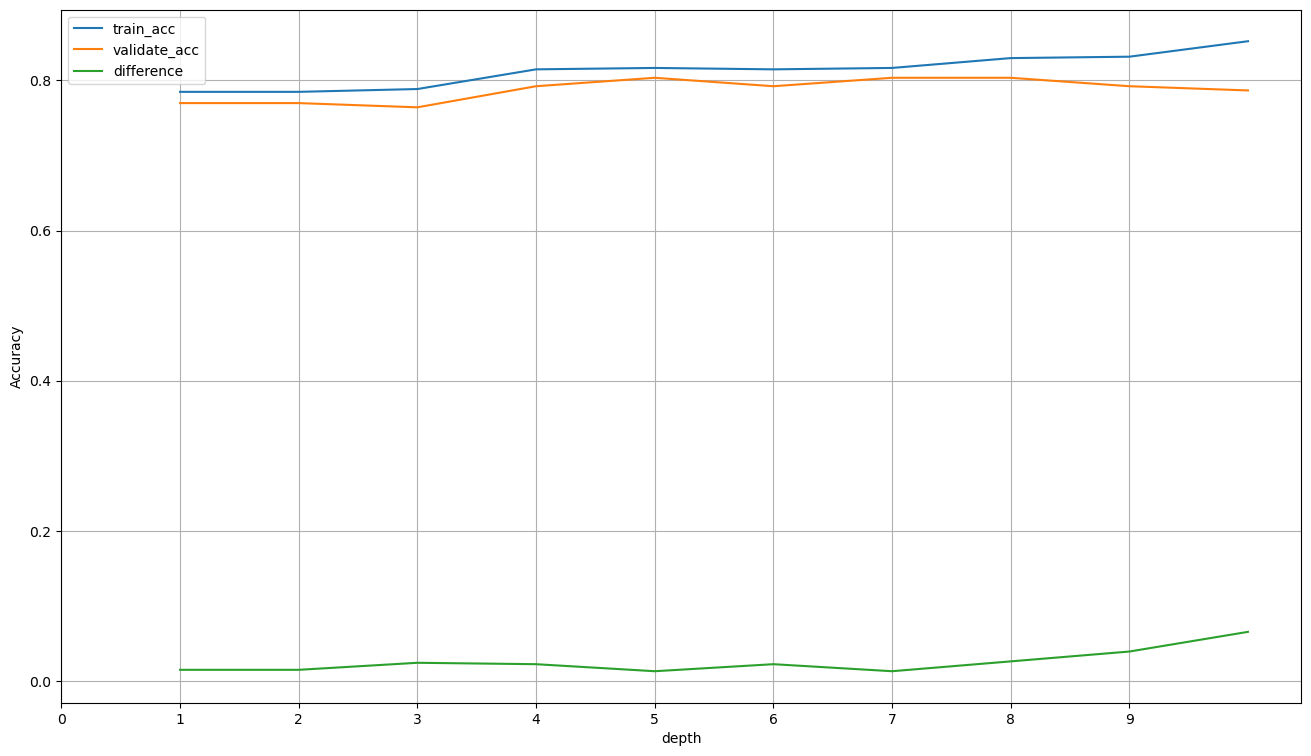

In [33]:
df.set_index('depth').plot(figsize = (16,9))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,10,1))
plt.grid()